In [80]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [81]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)

#

df["day_number"] = df.index + 1

#

df  = mpt.counter_for_maintenance(df , "2020-02-01 00:00:00", f1_finish)
df  = mpt.counter_for_maintenance(df , f1_finish, f2_finish)
df  = mpt.counter_for_maintenance(df , f2_finish, f3_finish)
df  = mpt.counter_for_maintenance(df , f3_finish, f4_finish)
df = mpt.counter_for_maintenance(df, f4_finish, "2020-09-01 03:59:51")

#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =["counter",'day_number','TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)

#

df_clustered = mpt.apply_kmeans_clustering(df_scaled, 5, "condition")


BACK_UP

In [83]:
df_back_up = df_clustered.copy()

MORE FEATURE ENGINEERING

In [84]:
df = df_back_up.copy()
df1 = mpt.filter_rows_between_the_given_timestamps(df, mpt.adjust_datetime(f1_start, "backward", 2), mpt.adjust_datetime(f1_finish, "forward", 1))
df2 = mpt.filter_rows_between_the_given_timestamps(df, mpt.adjust_datetime(f2_start, "backward", 2), mpt.adjust_datetime(f2_finish, "forward", 1))
df3 = mpt.filter_rows_between_the_given_timestamps(df, mpt.adjust_datetime(f3_start, "backward", 2), mpt.adjust_datetime(f3_finish, "forward", 1))
df4 = mpt.filter_rows_between_the_given_timestamps(df, mpt.adjust_datetime(f4_start, "backward", 2), mpt.adjust_datetime(f4_finish, "forward", 1))


LOGISTIC PART

In [85]:
df_log_reg_train = pd.concat([df1, df2, df3], ignore_index=True).copy()
df_log_reg_test = df4.copy()

y_train = df_log_reg_train["condition"]
X_train=  df_log_reg_train.drop("condition", axis='columns')
X_train = X_train.drop("timestamp", axis= "columns")

y_test = df_log_reg_test["condition"]
X_test=  df_log_reg_test.drop("condition", axis='columns')
X_test = X_test.drop("timestamp", axis= "columns")


model = LogisticRegression()
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
# failure prediction part

# Olasılıkları sınıflara dönüştür (0.5 eşik değeri kullanarak)
y_pred = (y_proba >= 0.99999).astype(int)

# F1-score hesapla
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9314


IMPORTANT

In [87]:
# for early detection
df_ed = pd.DataFrame({"proba": y_proba, "condition": y_test})
df_ed

,proba,condition
1158969,0.041251,0
1158970,0.048853,0
1158971,0.077202,0
1158972,0.077949,0
1158973,0.085206,0
...,...,...
1181310,0.036049,0
1181311,0.027268,0
1181312,0.021923,0
1181313,0.019395,0


In [77]:
def update_condition_values(df, num_rows_before=3): # daha sonra fonksiyonıu değiştircem # unutma

    result = df.copy()

    condition_1_indices = result[result['condition'] == 1].index.tolist()
    
    indices_to_update = []
    
    for idx in condition_1_indices:
        # Önceki num_rows_before satırın indekslerini al
        start_idx = max(0, idx - num_rows_before)
        prev_indices = list(range(start_idx, idx))
        indices_to_update.extend(prev_indices)

    result.loc[indices_to_update, 'condition'] = 2
    
    return result

In [89]:
def condition_degistir(df, n_rows=3): # TEKRAR YAZILACAK

    # Veri çerçevesinin bir kopyasını oluşturalım
    df_copy = df.copy()
    
    # 'condition' sütunundaki değişimleri bulalım
    # Bir önceki değer 0 ve şimdiki değer 1 olan yerleri tespit edelim
    condition_change = (df_copy['condition'].shift(1) == 0) & (df_copy['condition'] == 1)
    
    # Değişim noktalarının indekslerini bulalım
    change_indices = df_copy[condition_change].index.tolist()
    
    # Her değişimden önce n_rows kadar satırı 2 ile değiştirelim
    for idx in change_indices:
        # n_rows kadar geriye gidelim, ancak negatif indeks oluşmamasına dikkat edelim
        start_idx = max(0, idx - n_rows)
        
        # Sadece condition değeri 0 olan satırları 2 ile değiştirelim
        for i in range(start_idx, idx):
            if df_copy.loc[i, 'condition'] == 0:
                df_copy.loc[i, 'condition'] = 2
    
    return df_copy

deneme1

In [1]:
df_ed1 = df_ed.copy()

df_ed1 = condition_degistir(df_ed1, 50)

df_ed1["condition"].value_counts()

NameError: name 'df_ed' is not defined

In [127]:
fffiltered_df = df_ed1[df_ed1["condition"] != 1]
fffiltered_df["condition"].value_counts()

condition
0    20674
2       50
Name: count, dtype: int64

In [128]:
fffiltered_df

,proba,condition
1158969,0.041251,0
1158970,0.048853,0
1158971,0.077202,0
1158972,0.077949,0
1158973,0.085206,0
...,...,...
1181310,0.036049,0
1181311,0.027268,0
1181312,0.021923,0
1181313,0.019395,0


In [120]:
fffiltered_df[fffiltered_df["proba"]>0.99]["condition"].value_counts()

condition
0    3671
2      50
Name: count, dtype: int64

In [122]:
import pandas as pd
import numpy as np

def group_rows_by_condition(df, group_size=400):
    """
    DataFrame'i belirtilen grup boyutunda (group_size) birleştirir.
    Her grup içinde eğer herhangi bir satırın condition değeri 2 ise, 
    o gruba ait condition değeri 2 olarak atanır, aksi halde 0 olur.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        İşlenecek DataFrame. 'condition' sütunu içermelidir.
    group_size : int, default=400
        Her bir grubun içereceği satır sayısı
    
    Returns:
    --------
    pandas.DataFrame
        Gruplandırılmış yeni DataFrame
    """
    # Toplam satır sayısını alıyoruz
    total_rows = len(df)
    
    # Kaç grup oluşacağını hesaplıyoruz (yukarı yuvarlama ile)
    num_groups = int(np.ceil(total_rows / group_size))
    
    # Sonuçları depolamak için boş liste oluşturuyoruz
    result_data = []
    
    for i in range(num_groups):
        # Mevcut grubu alıyoruz
        start_idx = i * group_size
        end_idx = min((i + 1) * group_size, total_rows)
        current_group = df.iloc[start_idx:end_idx]
        
        # Gruptaki condition değerlerini kontrol ediyoruz
        if 2 in current_group['condition'].values:
            group_condition = 2
        else:
            group_condition = 0
        
        # Grubun ortalama proba değerini hesaplıyoruz
        group_proba = current_group['proba'].mean()
        
        # Yeni satırı sonuç listesine ekliyoruz
        result_data.append({
            'group_id': i,
            'start_row': start_idx,
            'end_row': end_idx - 1,
            'row_count': end_idx - start_idx,
            'proba': group_proba,
            'condition': group_condition
        })
    
    # Sonuç listesini DataFrame'e dönüştürüyoruz
    result_df = pd.DataFrame(result_data)
    
    return result_df

In [178]:
olsun = group_rows_by_condition(fffiltered_df, 100)

In [184]:
olsun["proba"]

0      0.525999
1      0.412646
2      0.245068
3      0.579560
4      0.355633
         ...   
203    0.139722
204    0.144320
205    0.028219
206    0.187546
207    0.335685
Name: proba, Length: 208, dtype: float64

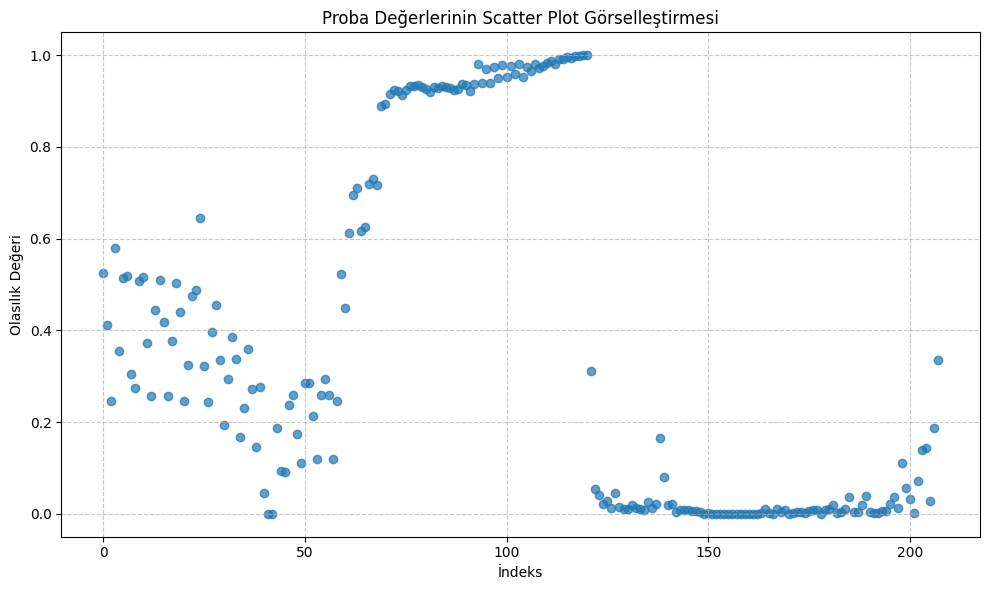

In [186]:
indeksler = np.arange(208)  # 0'dan 207'ye kadar indeksler
# Gerçek verilerinizi buraya yerleştirmelisiniz, ben örnek olarak rastgele değerler kullanıyorum
# proba = np.array([0.525999, 0.412646, 0.245068, ...]) # tüm değerler

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(indeksler, olsun["proba"], alpha=0.7)
plt.title('Proba Değerlerinin Scatter Plot Görselleştirmesi')
plt.xlabel('İndeks')
plt.ylabel('Olasılık Değeri')
plt.grid(True, linestyle='--', alpha=0.7)

# Görüntüyü ekranda göster
plt.tight_layout()
plt.show()

In [182]:
olsun[olsun["proba"]>0.99]["condition"]

113    0
114    0
115    0
116    0
117    0
118    0
119    0
120    2
Name: condition, dtype: int64